# Thinking About An Upcoming Election

In [1]:
# Inline Chart Parameters
%matplotlib inline

from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 9)

# Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

# Python Imports
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import us
from utils import *
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
polls = pd.read_csv('raw-polls.csv')
pres_polls_national = polls[(polls.type_detail=='Pres-G') & (polls.location == 'US')]
pres_polls_by_state = polls[(polls.type_detail=='Pres-G') & (polls.location != 'US')]

In [3]:
def margin_dotplot(df, x, y, figsize=(16,4)):
    """
    plot margin_poll (grey), average of margin_poll (white), and
    margin_actual (blue/red)
    """
    data = df.sort_values(by=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.stripplot(data=data,
                       x='margin_actual', y=y, orient='h', size=15,
                       hue=data['margin_actual'].apply(lambda x: 'D' if x > 0 else 'R'),
                       palette={'D':'blue', 'R': 'red'},
                       jitter=False, alpha=.25, ax=ax)

    sns.stripplot(data=data,
                       x=x, y=y, orient='h', size=15,
                       jitter=False, alpha=.35, color='grey', ax=ax)        

    data = (data.pivot_table(index=y, values=x, aggfunc='mean')
                .sort_values(by=y)
                .reset_index())

    sns.stripplot(data=data,
                  x=x, y=y, orient='h', size=15,
                  color='white', linewidth=1, jitter=False, ax=ax)    
        
    plt.axvline(x=0, color='black', linewidth=0.8)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

def dotplot(df, x, y, figsize=(16,4)):
    """
    plot any arbitray x (grey) and y with the average of x (white)
    """
    data = df.sort_values(by=y)
    fig, ax = plt.subplots(figsize=figsize)
    sns.stripplot(data=data,
                       x=x, y=y, orient='h', size=15,
                       jitter=False, alpha=.35, color='grey', ax=ax)
    data = (data.pivot_table(index=y, values=x, aggfunc='mean')
                .sort_values(by=y)
                .reset_index())
    sns.stripplot(data=data,
                  x=x, y=y, orient='h', size=15,
                  color='white', linewidth=1, jitter=False, ax=ax)
    plt.axvline(x=0, color='black', linewidth=0.8)
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

## So how are the polls doing? 

Lets look at the Nationwide popular vote. First, an exploratory visualization.

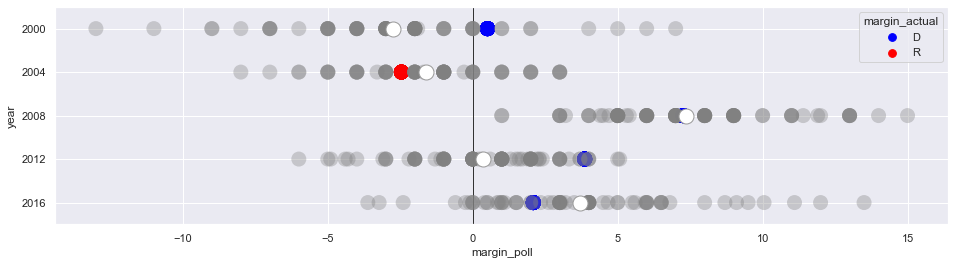

In [4]:
margin_dotplot(pres_polls_national, x='margin_poll', y='year')

Have the polls been getting increasingly biased? Now that we've glanced at the data, lets calculate the average error.

In [5]:
pres_polls_national[['year', 'bias']].groupby('year').mean()

,bias
year,
2000,-3.274062
2004,0.855000
2008,0.082857
2012,-3.513837
2016,1.618472


## But, we don't have one Presidential election ... we have 50 separate ones....

...and the nationwide polls can only tell us so much about who might win the election. So what about state polling? Has it been getting better or worse over the years? Can we still rely on it this coming election cycle? 

Lets start by digging into 2016 state polls.


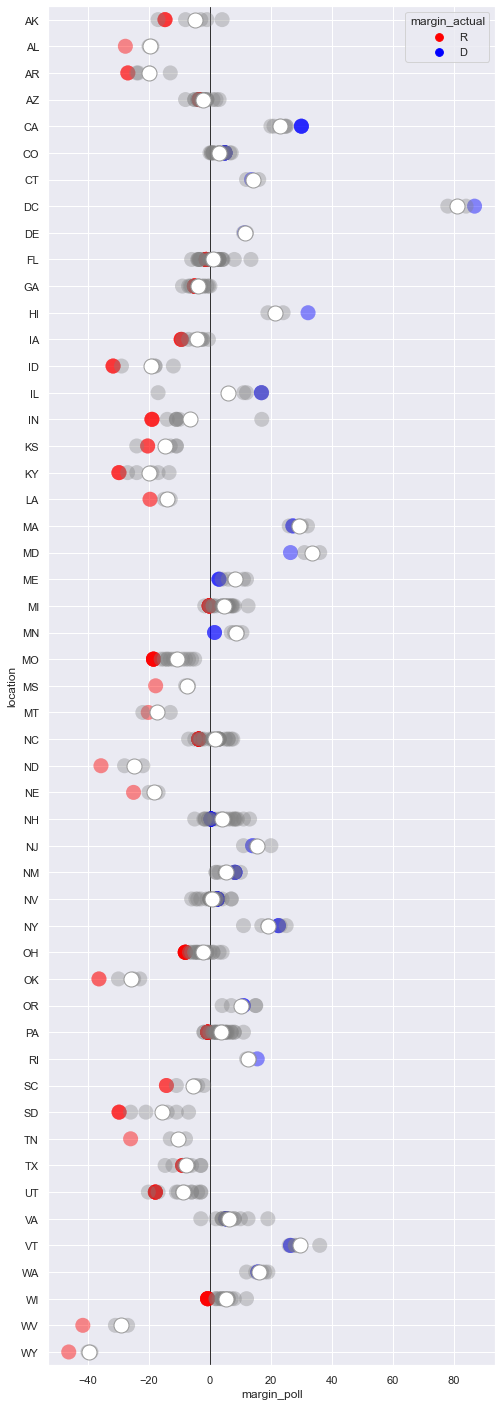

In [6]:
pres_polls_by_state_2016 = pres_polls_by_state[pres_polls_by_state.year == 2016]
margin_dotplot(pres_polls_by_state_2016, x='margin_poll', y='location', figsize=(8,25))

### Try it yourself! 

- Plot 2016 polls by pollster instead of state
- Look at a state with a big miss or very accurate polling in 2016
    - Filter down to that state and look at polling across all years. 
    - Does that state have a history of more or less accurate polling?
    - Check out some other states you think might be interesting.
    - Tell me about Hawaii.

Bonus: 
- Look into Senate polling from 2016. How did the polls fare?
    


## Ok, cool. But back to our question. Has statewide polling been getting more or less reliable?

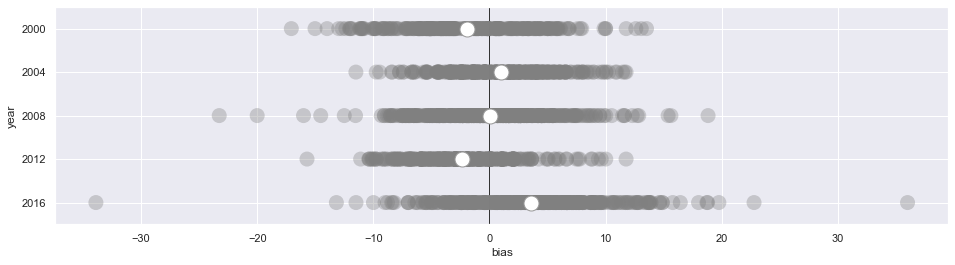

In [7]:
dotplot(pres_polls_by_state, x='bias', y='year', figsize=(16,4))

In [8]:
pres_polls_by_state[['year', 'bias']].groupby('year').mean()

,bias
year,
2000,-1.966633
2004,0.989412
2008,0.089742
2012,-2.328907
2016,3.546658


# Part 2: Statistical Treatment

Statistical treatment can help you get more out of a dataset! Sometimes the polls miss, but have consistent biases one way or another. If we can detect these patterns, we can correct for them and get more out of the data. Here is one example of how.

https://fivethirtyeight.com/features/how-fivethirtyeight-calculates-pollster-ratings/

In [9]:
polls = pd.read_csv('raw-polls.csv')
pollster_ratings = pd.read_csv('pollster-ratings.csv').set_index('Pollster')

pollster_mapping = {
    'Field Research Corporation (Field Poll)': 'Field Research Corp. (Field Poll)',
    'Selzer & Company': 'Selzer & Co.',
    'Ed Renwick/Loyola University': 'Ed Renwick/Loyola University New Orleans',
    'Abt SRBI': 'Abt Associates',
    'Marquette Law School': 'Marquette University Law School',
    'Google Consumer Surveys': 'Google Surveys',
    'Fox News/Anderson Robbins Research/Shaw & Company Research': 'Fox News/Anderson Robbins Research/Shaw & Co. Research',
    'Craciun Research': 'Craciun Research Group',
    'Cygnal Political': 'Cygnal',
    'US News & World Report': 'U.S. News & World Report',
    'Red Racing Horses': 'RRH Elections',
}

polls['pollster'] = polls.pollster.apply(lambda x: x.replace(', Inc.', ' Inc.'))
polls['pollster'] = polls.pollster.apply(lambda x: x.replace(', LLC', ' LLC'))
polls['pollster'] = polls.pollster.apply(lambda x: pollster_mapping.get(x, x))

polls['grade'] = polls.pollster.apply(lambda x: pollster_ratings.loc[x]['538 Grade'] if x in pollster_ratings.index else None)
polls['mrb'] = polls.pollster.apply(lambda x: pollster_ratings.loc[x]['Mean-Reverted Bias'] if x in pollster_ratings.index else None)
polls['mrb'] = pd.to_numeric(polls['mrb'].str.replace('D +', '', regex=False).str.replace('R +', '-', regex=False))

polls['margin_poll_adjusted'] = polls['margin_poll'] - polls['mrb']
polls['bias_adjusted'] = polls.margin_poll_adjusted - polls.margin_actual
polls['error_adjusted'] = np.abs(polls.margin_poll_adjusted - polls.margin_actual)

pres_polls_national = polls[(polls.type_detail=='Pres-G') & (polls.location == 'US')]
pres_polls_by_state = polls[(polls.type_detail=='Pres-G') & (polls.location != 'US')]

pres_polls_national_2016 = pres_polls_national[pres_polls_national.year == 2016]
pres_polls_by_state_2016 = pres_polls_by_state[pres_polls_by_state.year == 2016]

In [10]:
pres_polls_national_2016[['bias', 'bias_adjusted']].mean()

bias             1.618472
bias_adjusted    1.287917
dtype: float64

In [11]:
pres_polls_by_state_2016[['bias', 'bias_adjusted']].mean()

bias             3.546658
bias_adjusted    2.086658
dtype: float64

Hey cool! Adjustment improves the polls. Lets apply it EVERYWHERE!!!

In [12]:
tmpdf = pres_polls_by_state_2016.groupby('location') # 'error': 'mean', 'error_adjusted': 'mean'

tmpdf = pd.concat([
    tmpdf.agg({'bias': 'mean', 'bias_adjusted': 'mean'}),
    pd.DataFrame(tmpdf.size()),
], axis=1)
tmpdf['difference'] = np.abs(tmpdf.bias) - np.abs(tmpdf.bias_adjusted)
tmpdf.sort_values(by=0, ascending=False)

,bias,bias_adjusted,0,difference
location,,,,
FL,2.293030,1.796061,33,0.496970
PA,4.463704,3.934074,27,0.529630
NC,5.382083,4.861250,24,0.520833
NV,-1.867619,-2.243810,21,-0.376190
NH,3.685263,2.895789,19,0.789474
MI,4.985789,4.027895,19,0.957895
VA,1.062353,0.156471,17,0.905882
AZ,1.375000,0.531250,16,0.843750
OH,5.939375,5.233125,16,0.706250


Ok, so maybe it only sometimes improves the polls? Lets look at a few particular cases.

In [13]:
pres_polls_by_state_2016[pres_polls_by_state_2016.location == "DC"][['pollster', 'grade', 'margin_actual', 'margin_poll', 'margin_poll_adjusted', 'mrb', 'bias', 'bias_adjusted']]

,pollster,grade,margin_actual,margin_poll,margin_poll_adjusted,mrb,bias,bias_adjusted
7864,SurveyMonkey,D-,86.78,84.0,79.1,4.9,-2.78,-7.68
8257,SurveyMonkey,D-,86.78,78.0,73.1,4.9,-8.78,-13.68


Still, in the aggregate, you're better off looking at an adjusted average of the polls.

## Polls Stories

- https://fivethirtyeight.com/features/how-much-the-polls-missed-by-in-every-state/
- https://fivethirtyeight.com/features/pollsters-probably-didnt-talk-to-enough-white-voters-without-college-degrees/
- https://fivethirtyeight.com/features/what-a-difference-2-percentage-points-makes/
- https://fivethirtyeight.com/features/shy-voters-probably-arent-why-the-polls-missed-trump/
- https://fivethirtyeight.com/features/the-polls-missed-trump-we-asked-pollsters-why/
- https://fivethirtyeight.com/features/why-fivethirtyeight-gave-trump-a-better-chance-than-almost-anyone-else/
- https://fivethirtyeight.com/features/the-polls-are-all-right/
- https://fivethirtyeight.com/features/trump-is-just-a-normal-polling-error-behind-clinton/


# The 2018 FiveThirtyEight Forecasts

- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/senate
- https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house

# Some other folks

- [CNN](https://www.cnn.com/election/2018/forecast)
- [Daily Kos](https://elections.dailykos.com/)
- [New York Times - Real Time Polling!](https://www.nytimes.com/interactive/2018/upshot/elections-polls.html)


# Visualizing Uncertainty

- FiveThirtyEight in [2010](https://www.nytimes.com/elections/2010/forecasts/senate.html), [2014](https://fivethirtyeight.com/interactives/senate-forecast/), [2016](https://projects.fivethirtyeight.com/2016-election-forecast/), [2018](https://projects.fivethirtyeight.com/2018-midterm-election-forecast/house/)
    * I think 2010 still works in Safari...
- New York Times
    * The Spinners https://www.nytimes.com/2014/11/01/upshot/how-confirmation-bias-can-lead-to-a-spinning-of-wheels.html
    * The Needle https://www.youtube.com/watch?v=iq5rW6zYeP4
- [Huffpost's](http://elections.huffingtonpost.com/pollster) custom charts.

